<a href="https://colab.research.google.com/github/RuolinZheng08/playground/blob/master/epidemic-network/epidemic_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 25100 Spring 2020 Project

Modeling the spread of disease on an SIR network.

## README

```python
simulate(num_nodes, prob_conn, prob_infect, prob_remove, num_init_infections, 
             num_epochs, prob_hub_infect=None, hub_size=None, outfname=None)
```

In [0]:
import io
from IPython import display
from PIL import Image
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

## Vanilla SIR

In [0]:
class EpidemicNetwork:
  """
  A vanilla SIR network without dynamic hubs
  """
  def __init__(self, num_nodes, prob_conn, prob_infect, prob_remove):
    """
    prob_conn: the Bernoulli r.v. probability that an edge exists between
    two nodes
    prob_infect: the Bernoulli r.v. probability that an infected node will 
    infect its immediate neighbor in one time step
    num_infected: the number of nodes infected at time 0
    """
    self.network = nx.erdos_renyi_graph(num_nodes, prob_conn)
    self.num_nodes = num_nodes
    self.prob_infect = prob_infect
    self.prob_remove = prob_remove

    self.suspectible = set(range(num_nodes))
    self.infected = set()
    self.removed = set()

    # for vis and plotting
    self.vis_pos = nx.spring_layout(self.network)
    self.s_counts = []
    self.i_counts = []
    self.r_counts = []

  # helper for sampling a subset of nodes w/o replacement
  def sample_nodes(self, num):
    sample = np.random.choice(np.arange(self.num_nodes), num, replace=False) 
    return sample

  def init_infection(self, num_infected):
    temp_infect = self.sample_nodes(num_infected)
    for node in temp_infect:
      self.infected.add(node)
      self.suspectible.remove(node)
    self.record_stats()

  def step(self):
    """
    XXX: first remove individuals before infecting new ones
    this part is tricky because changing the order of removing and infecting
    may affect the result
    """

    # walkaround so as not to change the size of the set while iterating over it
    temp_infected = set()
    temp_removed = set()
    for node in self.infected:
      if np.random.binomial(1, self.prob_remove) == 1: # Bernoulli
        self.removed.add(node)
        temp_removed.add(node)
        continue # can no longer infect others in the current iteration

      for adj in self.network.neighbors(node):
        if adj in self.infected or adj in temp_infected or adj in self.removed:
          # already infected before or during the current iteration, or removed
          continue
        else:
          if np.random.binomial(1, self.prob_infect) == 1: # Bernoulli
            temp_infected.add(adj)
            self.suspectible.remove(adj)

    # update removed and infected
    self.infected.update(temp_infected)
    for node in temp_removed:
      self.infected.remove(node)
    # finally, record the new counts
    self.record_stats()

  # helpers for visualization, stats, and plotting
  def visualize(self):
    # cyan for S, red for I, and gray for R
    plt.figure()
    nx.draw_networkx_nodes(self.network, self.vis_pos, nodelist=self.suspectible, 
                           node_color='cyan')
    nx.draw_networkx_nodes(self.network, self.vis_pos, nodelist=self.infected, 
                           node_color='red')
    nx.draw_networkx_nodes(self.network, self.vis_pos, nodelist=self.removed, 
                           node_color='gray')
    nx.draw_networkx_edges(self.network, self.vis_pos)
    nx.draw_networkx_labels(self.network, self.vis_pos)
    # plt.show()
    fig = plt.gcf()
    plt.close() # suppress show
    return fig

  def record_stats(self):
    self.s_counts.append(len(self.suspectible))
    self.i_counts.append(len(self.infected))
    self.r_counts.append(len(self.removed))

  def plot_summary(self, num_epochs):
    plt.figure()
    plt.plot(self.s_counts, label='S')
    plt.plot(self.i_counts, label='I')
    plt.plot(self.r_counts, label='R')
    plt.yticks(np.arange(0, self.num_nodes + 1, 5, dtype='int'))
    plt.xticks(np.arange(0, num_epochs + 1, 5, dtype='int'))
    plt.xlabel('# epochs')
    plt.ylabel('# nodes')
    plt.legend()
    return plt.gcf()

## Dynamic Hub

In [0]:
class DynamicEpimdeicNetwork(EpidemicNetwork):
  def __init__(self, num_nodes, prob_conn, prob_infect, prob_remove, prob_hub_infect, hub_size):
    super().__init__(num_nodes, prob_conn, prob_infect, prob_remove)
    nx.set_edge_attributes(self.network, prob_infect, 'prob_infect') # val: key
    self.prob_hub_infect = prob_hub_infect
    self.hub_size = hub_size # TODO: can also use dynamic hub size
    self.hub_edges = None

  def gather(self):
    subgraph_nodes = self.sample_nodes(self.hub_size)
    self.hub_edges = set(combinations(subgraph_nodes, 2))
    attrs = {edge: {'prob_hub_infect': self.prob_hub_infect} for edge in self.hub_edges}
    self.network.add_edges_from(self.hub_edges)
    nx.set_edge_attributes(self.network, attrs)
  
  def undo_gather(self):
    for edge in self.hub_edges:
      attrs = self.network.edges[edge[0], edge[1]]
      if 'prob_infect' in attrs: # originally connected by prob_infect
        attrs.pop('prob_hub_infect', None) # remove the hub attribute
      else:
        self.network.remove_edge(*edge) # just discard it
    # don't clear the hub now b/c need it for visualization

  def step(self):
    self.hub_edges = None # clear previous hub
    self.gather()
    
    # copied from superclass, consider refactoring
    temp_infected = set()
    temp_removed = set()
    for node in self.infected:
      if np.random.binomial(1, self.prob_remove) == 1: # Bernoulli
        self.removed.add(node)
        temp_removed.add(node)
        continue # can no longer infect others in the current iteration

      for adj in self.network.neighbors(node):
        if adj in self.infected or adj in temp_infected or adj in self.removed:
          # already infected before or during the current iteration, or removed
          continue
        else: # normal prob or hub prob?
          if 'prob_hub_infect' in self.network.edges[node, adj]: # use hub
            bernoulli = np.random.binomial(1, self.prob_hub_infect)
          else:
            bernoulli = np.random.binomial(1, self.prob_infect)
          if bernoulli == 1:
            temp_infected.add(adj)
            self.suspectible.remove(adj)

    # update removed and infected
    self.infected.update(temp_infected)
    for node in temp_removed:
      self.infected.remove(node)
    # finally, record the new counts
    self.record_stats()

    self.undo_gather()

  def visualize(self):
    # cyan for S, red for I, and gray for R
    # tan for non-hub edges, and brown for hub edges
    plt.figure()
    nx.draw_networkx_nodes(self.network, self.vis_pos, nodelist=self.suspectible, 
                           node_color='cyan')
    nx.draw_networkx_nodes(self.network, self.vis_pos, nodelist=self.infected, 
                           node_color='red')
    nx.draw_networkx_nodes(self.network, self.vis_pos, nodelist=self.removed, 
                           node_color='gray')
    nx.draw_networkx_edges(self.network, self.vis_pos, edge_color='tan')
    if self.hub_edges is not None:
      nx.draw_networkx_edges(self.network, self.vis_pos, edgelist=self.hub_edges,
                            edge_color='brown')
    nx.draw_networkx_labels(self.network, self.vis_pos)
    fig = plt.gcf()
    plt.close() # suppress show
    return fig


## Simulation

In [0]:
# helper to convert plt.fig to PIL Image
def fig_to_img(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png')
  buf.seek(0)
  im = Image.open(buf)
  # buf.close() # don't close the buffer b/c need to save GIF
  return im

In [0]:
def simulate(num_nodes, prob_conn, prob_infect, prob_remove, num_init_infections, 
             num_epochs, prob_hub_infect=None, hub_size=None, outfname=None):
  # np.random.seed()
  imglist = []
  if prob_hub_infect is None: # use vanilla
    nw = EpidemicNetwork(num_nodes, prob_conn, prob_infect, prob_remove)
  else: # use dynamic hub
    nw = DynamicEpimdeicNetwork(num_nodes, prob_conn, prob_infect, prob_remove, 
                                prob_hub_infect, hub_size)
  if outfname:
    fig = nw.visualize()
    fig.suptitle('Initial State')
    imglist.append(fig_to_img(fig))
  # patient zero
  nw.init_infection(num_init_infections)
  if outfname:
    fig = nw.visualize()
    fig.suptitle('Patient Zero')
    imglist.append(fig_to_img(fig))
  for e in range(num_epochs):
    nw.step()
    title = 'Epoch {}, S: {}, I: {}, R: {}'.format(e, nw.s_counts[-1], 
                                                   nw.i_counts[-1], nw.r_counts[-1])
    print(title)
    if outfname:
      fig = nw.visualize()
      fig.suptitle(title)
      im = fig_to_img(fig)
      imglist.append(im)
      if e % 5 == 0: # show static visualization every 5 epochs
        im.show()
    
    # convergence criteria
    # if len(nw.suspectible) == 0:
    #   print('No more nodes in S. Stopping...')
    #   break

  # GIF, duration unit: millisec
  imglist[0].save(outfname, save_all=True, append_images=imglist[1:], 
                  duration=num_epochs*150, loop=0)
  plt.clf()
  # finally, plot summary of the three curves
  nw.plot_summary(num_epochs)

Epoch 0, S: 17, I: 3, R: 0
Epoch 1, S: 14, I: 5, R: 1
Epoch 2, S: 12, I: 7, R: 1
Epoch 3, S: 9, I: 9, R: 2
Epoch 4, S: 7, I: 10, R: 3
Epoch 5, S: 7, I: 6, R: 7
Epoch 6, S: 7, I: 6, R: 7
Epoch 7, S: 6, I: 6, R: 8
Epoch 8, S: 6, I: 6, R: 8
Epoch 9, S: 6, I: 6, R: 8


<Figure size 432x288 with 0 Axes>

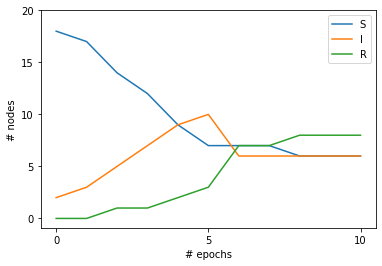

In [0]:
# simulate a vanilla SIR network
simulate(20, 0.2, 0.3, 0.15, 2, 10, outfname='out.gif')

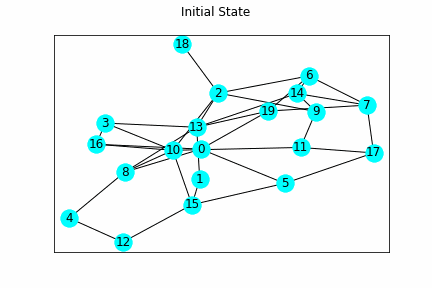

In [0]:
display.Image('out.gif', format='png')

Epoch 0, S: 9, I: 11, R: 0
Epoch 1, S: 5, I: 13, R: 2
Epoch 2, S: 1, I: 15, R: 4
Epoch 3, S: 1, I: 11, R: 8
Epoch 4, S: 1, I: 9, R: 10
Epoch 5, S: 0, I: 9, R: 11
Epoch 6, S: 0, I: 8, R: 12
Epoch 7, S: 0, I: 7, R: 13
Epoch 8, S: 0, I: 6, R: 14
Epoch 9, S: 0, I: 4, R: 16
Epoch 10, S: 0, I: 2, R: 18
Epoch 11, S: 0, I: 2, R: 18
Epoch 12, S: 0, I: 2, R: 18
Epoch 13, S: 0, I: 2, R: 18
Epoch 14, S: 0, I: 2, R: 18
Epoch 15, S: 0, I: 0, R: 20
Epoch 16, S: 0, I: 0, R: 20
Epoch 17, S: 0, I: 0, R: 20
Epoch 18, S: 0, I: 0, R: 20
Epoch 19, S: 0, I: 0, R: 20


<Figure size 432x288 with 0 Axes>

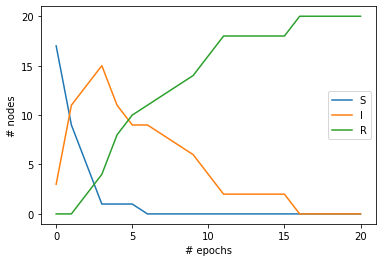

In [0]:
simulate(20, 0.4, 0.3, 0.2, 3, 20, prob_hub_infect=0.2, hub_size=4, outfname='hub.gif')

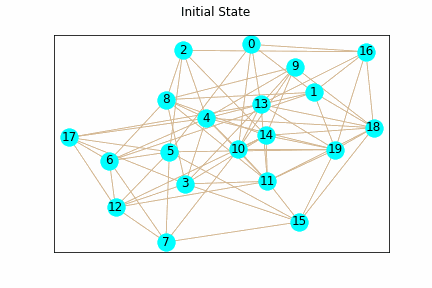

In [0]:
display.Image('hub.gif', format='png')